### Data Loader log analyser
Text report
- Responses count
- Unique entities count
- Avg. response time
- Stats by response code (requests count and avg. response time)
- Stats by process

Drawing charts
- Requests per time
- Avg. response time
- Response time by status code

In [395]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [396]:
load_dotenv()
reports_folder = os.environ.get('REPORTS_FOLDER')

#### Edit log file name below

In [397]:
report_file = "20230501_152144.log"

groupby_type = "MINUTES" # SECONDS

In [398]:
# Reading data from file
# Filtering lines in wrong format
file = open(reports_folder + report_file, 'r')

data = []
skipped_rows = 0
while file:
    line = file.readline()
    if line == "":
        break
        
    values = line.strip().split(";")
    if len(values) != 6:
        skipped_rows += 1
    else:
        data.append(values)
        
print("Log parsing results:")
print(f"- Lines loaded {len(data)}")
print(f"- Rows skipped {skipped_rows}")

Log parsing results:
- Lines loaded 6956
- Rows skipped 0


In [399]:
# Preparing data
# Converting formats
# Droping unnecessary cols

df_log = pd.DataFrame(data, columns=["Date", "Level", "Process", "Entity", "Code", "Response"])
df_warnings = df_log[df_log["Level"] == 'WARNING']
df_errors = df_log[df_log["Level"] == 'ERRORS']

df_log['Date'] = pd.to_datetime(df_log['Date'])
str_format = "%H:%M" if groupby_type == "MINUTES" else "%H:%M:%S" 
df_log['Time'] = df_log['Date'].dt.strftime(str_format)
    
# df_log['Code'] = df_log['Code'].astype(int)
df_log['Response'] = pd.to_timedelta(df_log['Response'])
df_log['Response time'] = df_log['Response'].dt.total_seconds()

df_log.drop(['Level', 'Date', 'Response'], axis=1, inplace=True)

print("Data sample")
print(tabulate(df_log.head(10), headers=["Process", "Entity", "Code", "Time", "Response time"], showindex=False))

Data sample
Process     Entity                                        Code  Time      Response time
----------  ------------------------------------------  ------  ------  ---------------
receiver-0  0xdca4b5f0eaba1f2eaae3aafb13e3836d6441e0a7     200  15:21          0.252333
receiver-2  0x3a03f68b9aab8d4aa68896cdf8583189206678dc     200  15:21          0.273487
receiver-1  0xc3986ac1e3c682f734c687c899d73da7e0524ad8     200  15:21          0.276738
receiver-0  0xa61301a5199671ab6c5d2e21c718fddbdab778e3     200  15:21          0.148259
receiver-1  0x3eb72125ff02a0e1e6276b66f0832835f4fc9337     200  15:21          0.142767
receiver-2  0x54a1f9674daaad0c61b346bf4018f4dd60390363     200  15:21          0.207395
receiver-0  0xec9ff02779c0580c757483a82f26729068f4f710     200  15:21          0.135049
receiver-1  0x778cb94a215518266448d7ae81bd4a734a7efc92     200  15:21          0.137161
receiver-2  0xae9ae50c6717e214a9e5a4c4d06a12e0d7741331     200  15:21          0.142592
receiver-0  0x24555b

In [400]:
# Preparing text report
print(f"Text report:\n")

# Responses count
responses_count = len(df_log.index)
print(f"1. Responses count: {responses_count}\n")

# Unique entities
unique_entities_count = len(pd.unique(df_log['Entity']))
print(f"2. Unique entities count: {unique_entities_count}\n")

# Avg response time
avg_response_time = df_log['Response time'].mean()
print(f"3. Avg. response time: {round(avg_response_time, 4)}s.\n")

# Stats by code
responses_by_code = (df_log.groupby("Code").agg(
                                            Count=('Entity', 'count'), 
                                            AvgResponseTime=('Response time', 'mean')))

responses_by_code = responses_by_code.reset_index().sort_values("Count", ascending=False)

print("4. Stats by response code\n")
_headers = ['Status code', "Requests count", "Avg. response time"]
print(tabulate(responses_by_code, headers=_headers, showindex=False))
print("\n")

# Avg response time by code
print("5. Stats by process\n")
responses_by_process = (df_log.groupby(["Process"]).agg(
                                            Count=('Entity', 'count'), 
                                            AvgResponseTime=('Response time', 'mean')))
responses_by_process = responses_by_process.reset_index()
responses_by_process = responses_by_process.sort_values("Count", ascending=False)
_headers = ['Process', 'Requests count', 'Avg. responce time']
print(tabulate(responses_by_process, headers=_headers, showindex=False))

Text report:

1. Responses count: 6956

2. Unique entities count: 6956

3. Avg. response time: 0.1562s.

4. Stats by response code

  Status code    Requests count    Avg. response time
-------------  ----------------  --------------------
          200              6956              0.156216


5. Stats by process

Process       Requests count    Avg. responce time
----------  ----------------  --------------------
receiver-2              2339              0.154796
receiver-1              2315              0.156494
receiver-0              2302              0.15738


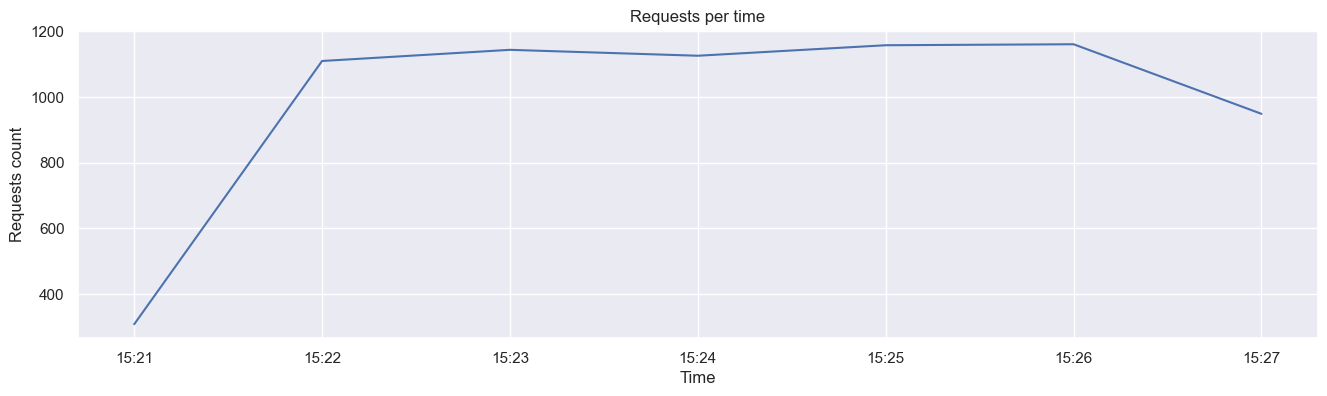

/var/folders/r1/xst6tg6n55j16dqjd7q2z4900000gp/T/ipykernel_69777/1616730839.py:16: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  plot_all = sns.scatterplot(data=df_requests_type, x="Time", y="Response time", hue="Code", palette=palette)


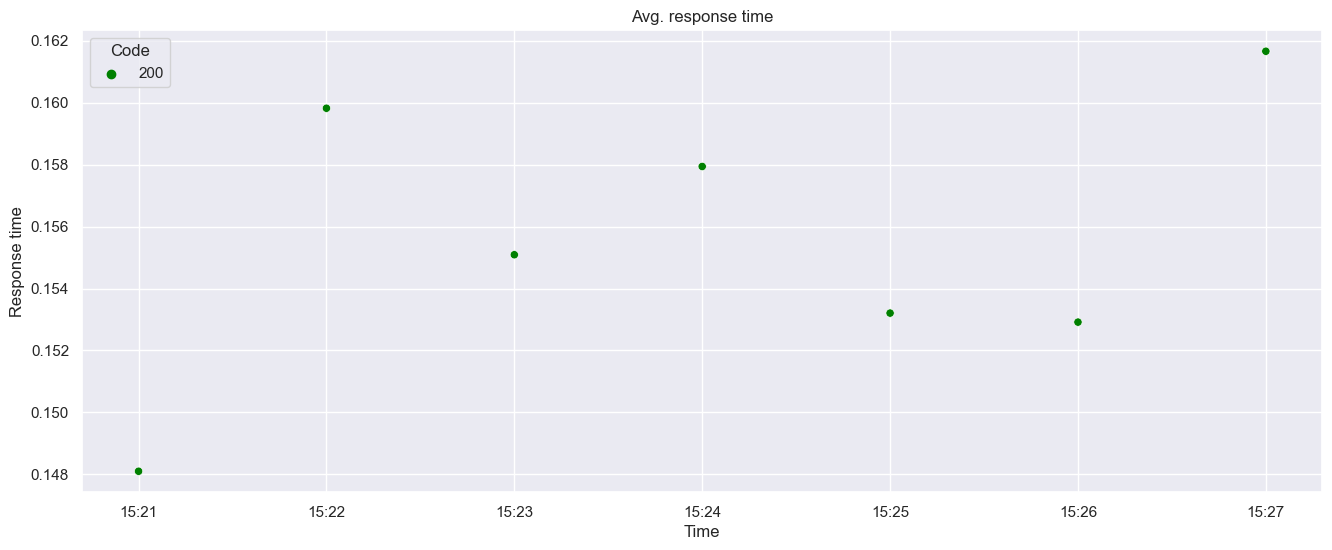

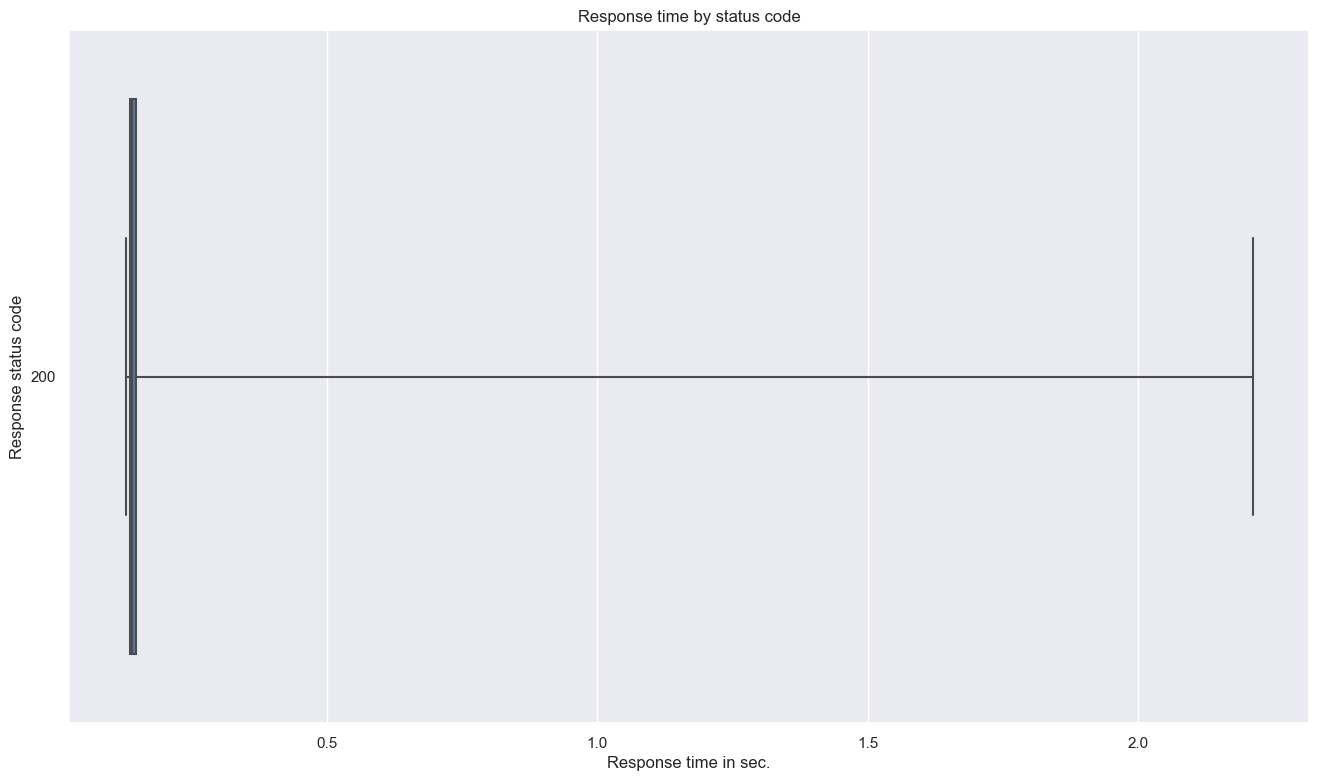

In [401]:
df_requests = df_log.groupby('Time').agg("Entity").count()

# Building request per time plot
plt.figure(figsize=(16, 4))
sns.set_theme()
plot = sns.lineplot(data=df_requests, markers=True)
plot.set(title='Requests per time', ylabel='Requests count')
plt.show()

# Building avg response time plot
plt.figure(figsize=(16, 6))
sns.set_theme()

df_requests_type = df_log.groupby(['Time', 'Code']).agg({"Entity": "count", "Response time": "mean"}).reset_index()
palette=['green','red'] #, 'orange','brown','dodgerblue']
plot_all = sns.scatterplot(data=df_requests_type, x="Time", y="Response time", hue="Code", palette=palette)
plot_all.set(title='Avg. response time')
plt.show()

# Preparing response time by status code plot
plt.figure(figsize=(16, 9))
sns.set_theme()

df_box = df_log
df_box['Code'] = df_box['Code'].astype(int)
plot = sns.boxplot(data=df_log, y="Code", x="Response time", whis=[0, 100], orient="h")
plot.set(title='Response time by status code', ylabel="Response status code", xlabel="Response time in sec.")

plt.show()

In [402]:
# Top slowest responses
limit = 20

df_log = df_log.sort_values('Response time', ascending=False)
sample = df_log.iloc[0:limit]

sample.reset_index(inplace=True, drop=True)

_headers = ['Process', 'Entity', 'Code', 'Time', 'Request time']
print(tabulate(sample, headers=_headers))

    Process     Entity                                        Code  Time      Request time
--  ----------  ------------------------------------------  ------  ------  --------------
 0  receiver-0  0xf6deb19a5f10abdef7a94b050f2d1eafd8955a0c     200  15:22         2.21295
 1  receiver-2  0x0c86262354095fa35a21b58af3e0dd94d0ba767c     200  15:22         1.48527
 2  receiver-0  0xf0d1a4130d52d9f9e3d2c1c1bb24a91f3201236b     200  15:27         1.29121
 3  receiver-0  0xdf4faed7f470639cc6fb534f80170960753c5e3b     200  15:27         1.28359
 4  receiver-1  0x8d76ca9a8be3f77bc8b4faa62a678c3fb17892cf     200  15:27         1.26372
 5  receiver-2  0x54a02d10e002dd89fbf81a1895185cb613043646     200  15:27         1.25406
 6  receiver-0  0x56178626332fc530561535eeaa914b863aa455f2     200  15:26         1.20985
 7  receiver-2  0x2e903d666b07e26dfb73382a068b5c7c9392132c     200  15:24         1.17966
 8  receiver-2  0x6574080a89289178426c3065eefa43982a3c2312     200  15:24         1.17063
 9  rece

In [403]:
#### Take a look on warnings and errors
print(df_warnings)
# df_warnings.to_csv("./warnings.csv", sep=";")
print(df_errors)

                                Date    Level     Process   
734  2023-05-01T15:22:23.185414+0200  WARNING  receiver-0  \

                                         Entity Code        Response  
734  0xf6deb19a5f10abdef7a94b050f2d1eafd8955a0c  200  0:00:02.212950  
Empty DataFrame
Columns: [Date, Level, Process, Entity, Code, Response]
Index: []
